In [1]:
# general imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


from astropy.constants import c
import astropy.units as u
from scipy.ndimage import gaussian_filter1d
# import the main class
from funcs.auroralring import AuroralRing

import numpy as np
import emcee


In [2]:

# inclination of rotation axis in radians with the right convention
i_rot = np.pi/2 - 90 * np.pi/180


# rotation period in days
P_rot = 2.845 / 24.
omega = 2 * np.pi / P_rot


# stellar radius in solar radii
R_star = (1.07 * u.R_jup).to(u.R_sun).value


phi = np.linspace(0, 2*np.pi, 100)

vmax = omega * R_star * 695700. / 86400. # km/s


def model(vbins, vmids, imag, phimin, dphi, alpha_0, ampl, broaden=10, N=11, foreshortening=True, subspecs=3): 

    # inclination of magnetic axis in radians relative to rotation axis
    i_mag = imag * np.pi / 180

    # upper latitude of ring around magnetic axis in radians
    PHI_max = (phimin + dphi) * np.pi / 180

    # lower latitude of ring around magnetic axis in radians
    PHI_min = phimin * np.pi / 180

    # width of ring around magnetic axis in radians
    width = PHI_max - PHI_min

    # mid latitude of ring around magnetic axis in radians
    mid_lat = (PHI_max + PHI_min) / 2


    # define the auroral ring
    ring = AuroralRing(i_rot=i_rot, i_mag=i_mag, latitude=mid_lat,
                        width=width, Rstar=R_star, P_rot=P_rot, N=60, 
                    v_bins=vbins, v_mids=vmids, omega=omega, vmax=vmax, phi=phi, gridsize=int(1e3))

    alpha_edges = np.linspace(alpha_0*2*np.pi, alpha_0*2*np.pi + 2*np.pi, (N-1)*subspecs)
    alphas = (alpha_edges[1:] + alpha_edges[:-1]) / 2

    # wav = ring.v_mids / 2.9979246e5 * 6562.8 + 6562.8
    ddv = ring.v_mids[1] - ring.v_mids[0]
    dv = broaden / ddv

    spectra = [ring.get_flux_numerically(alpha=alpha, normalize=False, foreshortening=foreshortening) for alpha in alphas]

    # sum every three spectra consecutively
    spectra = np.array([np.sum(spectra[i:i+subspecs], axis=0) for i in range(0, len(spectra), subspecs)])


    spectra = np.array([gaussian_filter1d(spectrum, dv) for spectrum in spectra])
    maxval = np.max(spectra)

    if maxval == 0:
        return np.ones_like(spectra[0]) 
    else:
        return spectra / maxval * ampl + 1

df = pd.read_csv('data/lsr_norm_spectra_median.csv', index_col=0, header=[0,1])

# select only index values between 6559 and 6566 
df = df.loc[(df.index > 6560.) & (df.index < 6565.5)]


x = df.index.values
diffx = np.diff(x)
vbins = np.linspace(x[0]-diffx[0]/2, x[-1]+diffx[-1]/2, len(x)+1)
vbins = ((vbins - 6562.8) / 6562.8 * c).to(u.km/u.s).value
vmids = (vbins[1:] + vbins[:-1]) / 2

# for each column in df, select the median subcolumn
ys = []
ystds = []

for col in df.columns.levels[0]:
    for subcol in df.columns.levels[1]:
        print(col, subcol)
        if subcol == "median":
            ys.append(df[col, subcol].values)
        elif subcol == "std":
            ystds.append(df[col, subcol].values)

# invert the order of ys and ystds
ys = ys[::-1]
ystds = ystds[::-1]

ys = np.array(ys)
ystds = np.array(ystds)

 

(0.0, 0.1] median
(0.0, 0.1] std
(0.1, 0.2] median
(0.1, 0.2] std
(0.2, 0.3] median
(0.2, 0.3] std
(0.3, 0.4] median
(0.3, 0.4] std
(0.4, 0.5] median
(0.4, 0.5] std
(0.5, 0.6] median
(0.5, 0.6] std
(0.6, 0.7] median
(0.6, 0.7] std
(0.7, 0.8] median
(0.7, 0.8] std
(0.8, 0.9] median
(0.8, 0.9] std
(0.9, 1.0] median
(0.9, 1.0] std


In [ ]:
# make a mcmc setup with emcee


def log_likelihood(theta, vbins, vmids, y, yerr):
    imag, phimin, dphi, alpha_0, ampl, broaden = theta
    model_ = model(vbins, vmids, imag, phimin, dphi, alpha_0, ampl, broaden)
    return  -0.5 * np.sum((y - model_) ** 2 / yerr ** 2)
 
def log_prior(theta):
    imag, phimin, dphi, alpha_0, ampl, broaden = theta
    if ((0 < imag < 90) and 
        (0 < phimin < 90) and 
        (0 < dphi < (90 - phimin)) and 
        (0 < alpha_0 < 1) and 
        (0 < ampl < 1e9) and 
        (5 < broaden < 25)):
        return 0.0
    return -np.inf

def log_probability(theta, x, vmids, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, vmids, y, yerr)

initial = [30, 60, 10, 0.2, 1.2, 15]
nwalkers = 32
ndim = len(initial)
pos = initial + 1e-4 * np.random.randn(nwalkers, ndim)
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(vbins, vmids, ys, ystds),)
                                # backend=emcee.backends.HDFBackend("chains.h5"))


sampler.run_mcmc(pos, 5000, progress=True);

  5%|▍         | 234/5000 [00:17<05:53, 13.50it/s]

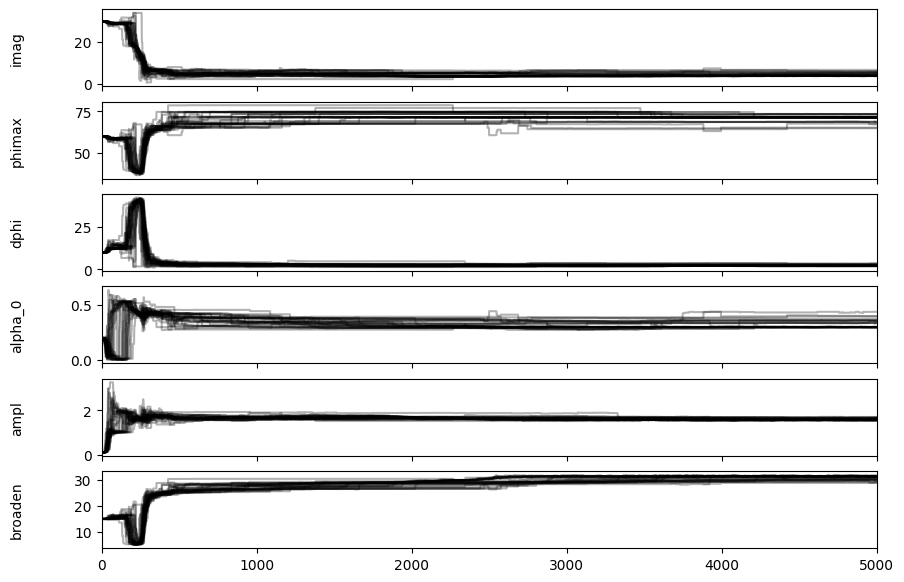

In [4]:
# plot chains
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["imag", "phimax", "dphi", "alpha_0", "ampl", "broaden"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

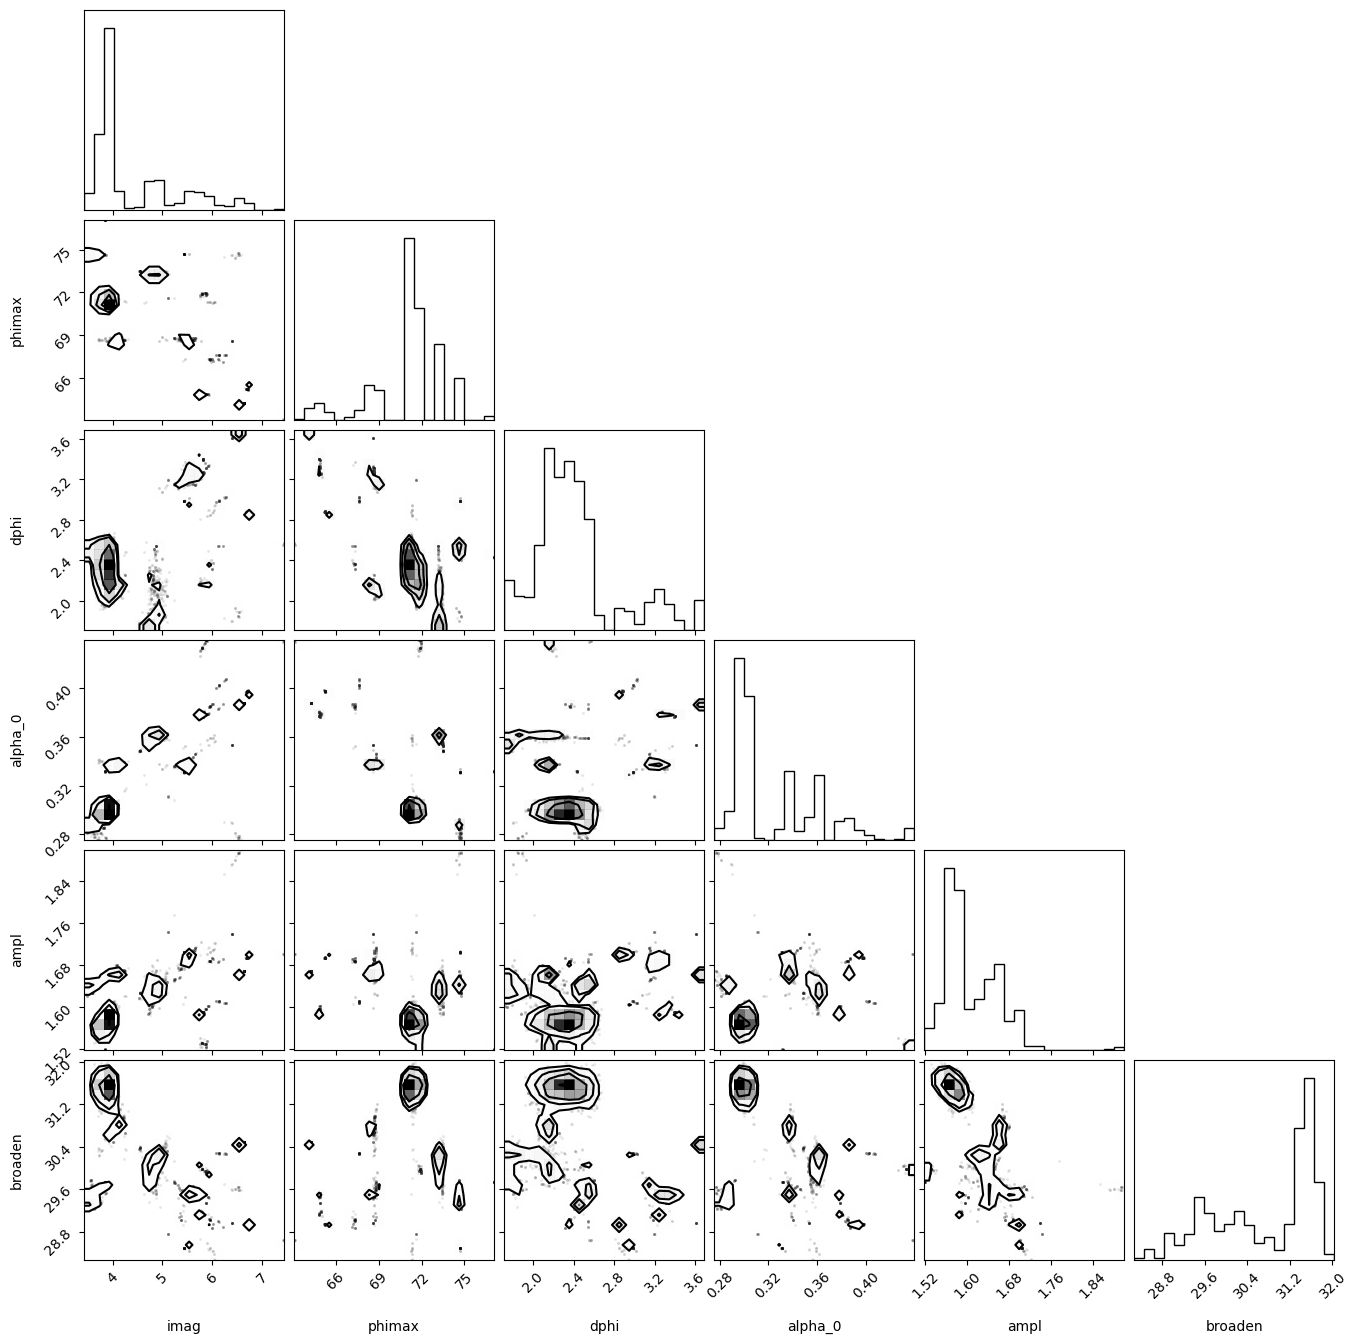

In [5]:
# corner plot
labels = ["imag", "phimax", "dphi", "alpha_0", "ampl", "broaden"]
import corner
flat_samples = sampler.get_chain(discard=3000, thin=15, flat=True)
fig = corner.corner(
    flat_samples, labels=labels, truths=initial
)

3.94, 71.44, 2.33, 0.3, 1.59, 31.23


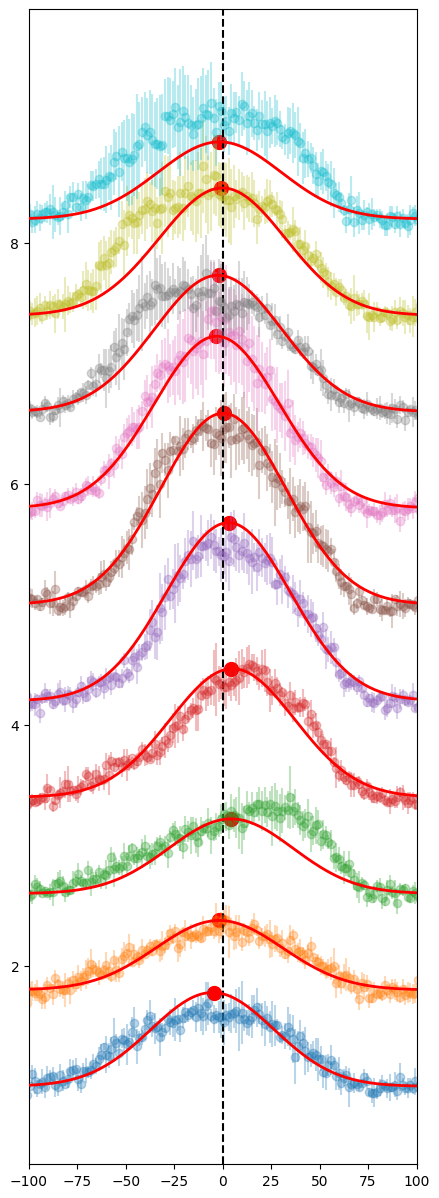

In [7]:
# plot best fit
imag, phimax, dphi, alpha_0, ampl, broaden = np.median(flat_samples, axis=0)
v_mids = (vbins[1:] + vbins[:-1]) / 2
m = model(vbins, vmids, imag, phimax, dphi, alpha_0, ampl, broaden)

plt.figure(figsize=(5, 15))

offset = 0
for y, std in zip(ys, ystds):
    plt.errorbar(v_mids, y + offset, yerr=std, fmt='o', alpha=0.3)
    offset += .8

offset = 0
for mod in m:
    plt.plot(v_mids, mod + offset, zorder=100, lw=2, c='r')
    # mark the maximum of the model
    plt.scatter(v_mids[np.argmax(mod)], np.max(mod) + offset, c='r', s=100)
    offset += .8

plt.xlim(-100,100)
plt.axvline(0, c='k', ls='--')


# round up the values to 2 decimals and print them
imag, phimax, dphi, alpha_0, ampl, broaden = np.round([imag, phimax, dphi, alpha_0, ampl, broaden], 2)
print(f"{imag}, {phimax}, {dphi}, {alpha_0}, {ampl}, {broaden}")

obliquity, upper limit ring latitude, width ring, start_phase, relative amplitude, broadening[km/s]

22.51, 14.87, 0.36, 0.64, 0.99, 20.75